# torch2tflite

In [1]:
!pip install -q git+https://github.com/rpnugroho/torch2tflite#egg=torch2tflite

     |████████████████████████████████| 12.7 MB 84 kB/s 
     |████████████████████████████████| 4.8 MB 42.8 MB/s 
     |████████████████████████████████| 222 kB 65.7 MB/s 
     |████████████████████████████████| 1.1 MB 12.3 MB/s 


## Using CLI

In [2]:
!torch2tflite vision --help

Usage: torch2tflite vision [OPTIONS] MODEL_NAME
                           OUTPUT

  Convert torchvision model from hub to TFLite.

  MODEL NAME : Model name i.e. "resnet50"

  OUTPUT     : Output name of TFLite model.

Options:
  -p, --pretrained BOOLEAN        If True, get
                                  torchvision
                                  model pre-
                                  trained on
                                  ImageNet

  -fp, --precision TEXT           Quantization
                                  type of TFLite
                                  model i.e.
                                  'float16'

  -i, --img-size <INTEGER INTEGER>...
                                  Size of input
                                  image i.e. 244
                                  244

  -b, --batch-size INTEGER        Batchsize i.e.
                                  32

  --help                          Show this
                                  message and
       

In [3]:
!torch2tflite vision "resnet50" "/content/resnet50.tflite" --img-size=224 224 -fp='float16'

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100% 97.8M/97.8M [00:00<00:00, 150MB/s]
Create temp directory
Converting to ONNX...
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
ONNX exported to /tmp/tmphi0wqs2f/resnet50.onnx
2021-11-06 14:18:16.600231: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2021-11-06 14:18:16.600303: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (7fe2340174cb): /proc/dri

## Using Python

In [4]:
import torch
from torch2tflite.converter import torch_to_tflite
from torch2tflite.utils import load_torchvision_model

output = "/content/resnet152.tflite"
dummy_input = torch.randn(32, 3, 224, 224)

model = load_torchvision_model(model_name="resnet152", pretrained=True)
torch_to_tflite(model=model, output=output, dummy_input=dummy_input, precision="float32")

Downloading: "https://download.pytorch.org/models/resnet152-394f9c45.pth" to /root/.cache/torch/hub/checkpoints/resnet152-394f9c45.pth


  0%|          | 0.00/230M [00:00<?, ?B/s]

Create temp directory
Converting to ONNX...


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


ONNX exported to /tmp/tmpf3owfqs7/resnet152.onnx
Converting to TFSavedModel...


INFO:tensorflow:Assets written to: /tmp/tmpf3owfqs7/resnet152/assets


INFO:tensorflow:Assets written to: /tmp/tmpf3owfqs7/resnet152/assets


TensorFlow savedmodel saved to /tmp/tmpf3owfqs7/resnet152
Converting to TFLite...
TFlite model saved to /content/resnet152.tflite
Clean temp directory


# Test TFLite

In [5]:
!wget http://cs231n.stanford.edu/tiny-imagenet-200.zip -q
!unzip -q tiny-imagenet-200.zip && ls tiny-imagenet-200 -q
!wget https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json -q

test  train  val  wnids.txt  words.txt


In [7]:
import numpy as np
import tensorflow as tf
# force a channel ordering
from tensorflow.keras import backend
# force channels-first ordering
backend.set_image_data_format('channels_first')

IMAGE_SHAPE = (224, 224)
TRAINING_DATA_DIR = "/content/tiny-imagenet-200/train"

datagen_kwargs = dict(rescale=1./255, validation_split=.20)
valid_datagen = tf.keras.preprocessing.image.ImageDataGenerator(**datagen_kwargs)
valid_generator = valid_datagen.flow_from_directory(
    TRAINING_DATA_DIR, 
    subset="validation", 
    shuffle=True,
    target_size=IMAGE_SHAPE
)

val_image_batch, val_label_batch = next(iter(valid_generator))
print("Validation batch shape:", val_image_batch.shape)

Found 20000 images belonging to 200 classes.
Validation batch shape: (32, 3, 224, 224)


In [8]:
# Load quantized TFLite model
tflite_interpreter = tf.lite.Interpreter(model_path="/content/resnet152.tflite")

# Learn about its input and output details
input_details = tflite_interpreter.get_input_details()
output_details = tflite_interpreter.get_output_details()

# Resize input and output tensors to handle batch of 32 images
# tflite_interpreter.resize_tensor_input(input_details[0]['index'], (32, 3, 224, 224))
# tflite_interpreter.resize_tensor_input(output_details[0]['index'], (32, 5))
tflite_interpreter.allocate_tensors()

input_details = tflite_interpreter.get_input_details()
output_details = tflite_interpreter.get_output_details()

print("== Input details ==")
print("name:", input_details[0]['name'])
print("shape:", input_details[0]['shape'])
print("type:", input_details[0]['dtype'])

print("\n== Output details ==")
print("name:", output_details[0]['name'])
print("shape:", output_details[0]['shape'])
print("type:", output_details[0]['dtype'])

# Run inference
tflite_interpreter.set_tensor(input_details[0]['index'], val_image_batch)

tflite_interpreter.invoke()

tflite_predictions = tflite_interpreter.get_tensor(output_details[0]['index'])
print("\nPrediction results shape:", tflite_predictions.shape)

== Input details ==
name: serving_default_actual_input:0
shape: [ 32   3 224 224]
type: <class 'numpy.float32'>

== Output details ==
name: PartitionedCall:0
shape: [  32 1000]
type: <class 'numpy.float32'>

Prediction results shape: (32, 1000)


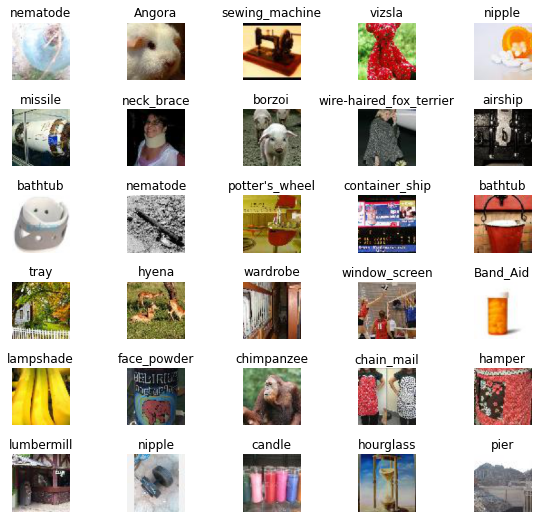

In [11]:
import json
import matplotlib.pylab as plt

class_idx = json.load(open("/content/imagenet_class_index.json"))
idx2label = [class_idx[str(k)][1] for k in range(len(class_idx))]

plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.5)
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.title(idx2label[np.argmax(tflite_predictions[n])])
  plt.axis('off')
  im2display = val_image_batch[n].transpose((1,2,0))
  plt.imshow(im2display)